# Parking Data Transformation

In [1]:
# Lets import our parking data
import geopandas as gpd
import pandas as pd
import numpy as np

file = "../data/Parking_Zones.geojson"
parking_zones = gpd.read_file(file)

Transform, clean, and reduce data down to exactly what we need:

- Zones for general parking rules, keeping the restriction days, hours, any possible data errors, etc.

## Parking Zones

Here, we take a look at what exists in the columns, and then extract only what is relevant, either for processing or metadata

In [2]:
print(parking_zones.columns)
print(parking_zones["PARKINGGROUP"].unique())

#Drop unnecessary columns

parking_zones = parking_zones[
    ["ZONEID", "PARKINGGROUP", "geometry", "STARTDAY", "ENDDAY", "STARTTIME", "ENDTIME", "SIDE", "DATA_ERRORS", "PARKINGDAYGROUP", "PARKINGHOURGROUP"]
]

Index(['ZONEID', 'MUTCD', 'SIGNTEXT', 'ROUTEID', 'SIDE', 'MEAS_FROM',
       'MEAS_TO', 'STARTDAY', 'ENDDAY', 'STARTTIME', 'ENDTIME', 'SIGNS',
       'OFFSET', 'SUBBLOCKID', 'SUBBLOCKKEY', 'BLOCKFACEKEY', 'SIGNCODE',
       'PARKINGGROUP', 'PARKINGDAYGROUP', 'PARKINGHOURGROUP', 'DATA_ERRORS',
       'EXCEPTION', 'GIS_ID', 'OBJECTID', 'SHAPE', 'GLOBALID', 'SHAPELEN',
       'geometry'],
      dtype='str')
<StringArray>
[       'NS',     'Timed',       'RPP',        'NP',        'LZ',       'ROP',
      'Paid',  'Sweeping',  'Reserved',      'Snow',      'PUDO',     'Event',
 'Emergency']
Length: 13, dtype: str


Here, we add four new columns:

- <i> RESTRICTED_DAYS_PER_WEEK</i> which gives us an idea of how many days of the week a restriction exists
- <i> RESTRICTED_HOURS_PER_WEEK</i> which gives us an idea of how many hours a week a restrictione exists
- <i> RESTRICTED_DAYS_PER_WEEK_ERROR</i> which we use to log any error that exists that would prevent us from calculating the restricted days per week
- <i> RESTRICTED_HOURS_PER_WEEK_ERROR</i> which we use to log any error that exists that would prevent us from calculating the restricted hours per week

It's worth noting that  we are just using total time of restriction as a metric, and not weighing it based on when that restriction occurs (weekend vs weekday, day vs night, etc.)

In [3]:
# New columns:
parking_zones["RESTRICTED_HOURS_PER_WEEK"] = 0.0
parking_zones["RESTRICTED_DAYS_PER_WEEK"] = 0.0
parking_zones["RESTRICTED_DAYS_PER_WEEK_ERROR"] = ""
parking_zones["RESTRICTED_HOURS_PER_WEEK_ERROR"] = ""

# Convert start/endday 8  to every day restriction
parking_zones.loc[parking_zones["STARTDAY"] == 8, "RESTRICTED_DAYS_PER_WEEK"] = 7
parking_zones.loc[parking_zones["ENDDAY"] == 8, "RESTRICTED_DAYS_PER_WEEK"] = 7

# Convert start/endday 9 to restricted on schooldays (180 of 365 days)
parking_zones.loc[parking_zones["STARTDAY"] == 9, "RESTRICTED_DAYS_PER_WEEK"] = 3.45205479452 
parking_zones.loc[parking_zones["ENDDAY"] == 9, "RESTRICTED_DAYS_PER_WEEK"] = 3.45205479452 

# Calculate restricted days per week for other cases
mask = (
    (parking_zones["STARTDAY"] != 8)
    & (parking_zones["ENDDAY"] != 8)
    & (parking_zones["STARTDAY"] != 9)
    & (parking_zones["ENDDAY"] != 9)
)
day_diff = parking_zones.loc[mask, "ENDDAY"] - parking_zones.loc[mask, "STARTDAY"]
valid = day_diff > 0

parking_zones.loc[mask & valid, "RESTRICTED_DAYS_PER_WEEK"] = day_diff[valid].abs() + 1
parking_zones.loc[mask & ~valid, "RESTRICTED_DAYS_PER_WEEK"] = np.nan
parking_zones.loc[mask & ~valid, "RESTRICTED_DAYS_PER_WEEK_ERROR"] = "Invalid day range"

# HOURS OF RESTRICTION:

# if start/endtime is 100, the hours are restricted all day
# otherwise, subtract endtime - starttime to get hours of restriction (but )
mask_all_day = (parking_zones["STARTTIME"] == 100) | (parking_zones["ENDTIME"] == 100)
parking_zones.loc[mask_all_day, "RESTRICTED_HOURS_PER_WEEK"] = 24 * parking_zones.loc[mask_all_day, "RESTRICTED_DAYS_PER_WEEK"]

# For non-all-day restrictions, calculate hours per day and multiply by restricted days per week
mask_not_all_day = ~mask_all_day
valid_times = (
    mask_not_all_day
    & parking_zones["STARTTIME"].notna()
    & parking_zones["ENDTIME"].notna()
    & ((parking_zones["ENDTIME"] - parking_zones["STARTTIME"]) > 0)
)

# Calculate hours per day for valid rows
hours_per_day = parking_zones.loc[valid_times, "ENDTIME"] - parking_zones.loc[valid_times, "STARTTIME"]
parking_zones.loc[valid_times, "RESTRICTED_HOURS_PER_WEEK"] = (
    hours_per_day)

# For invalid time ranges (difference <= 0), set NaN and add error message
invalid_times = (
    mask_not_all_day
    & (
        parking_zones["STARTTIME"].isna()
        | parking_zones["ENDTIME"].isna()
        | ((parking_zones["ENDTIME"] - parking_zones["STARTTIME"]) <= 0)
    )
)
parking_zones.loc[invalid_times, "RESTRICTED_HOURS_PER_WEEK"] = np.nan
parking_zones.loc[invalid_times, "RESTRICTED_HOURS_PER_WEEK_ERROR"] = "Invalid or missing time range"


## Dealing with missing/blank values

When dealing with missing values (errors from calculating hours of week), we fill in the missing value by averaging over the PARKINGGROUP and PARKINGHOURGROUP.

If issues persist, we average just over the PARKINGGROUP.

In [4]:
# average over parking group and parking hour group?

# Calculate average restricted hours per week by PARKINGGROUP and PARKINGHOURGROUP
avg_by_group = parking_zones.groupby(["PARKINGGROUP", "PARKINGHOURGROUP"])["RESTRICTED_HOURS_PER_WEEK"].transform("mean")

# Fill NaN values with the group averages
parking_zones.loc[parking_zones["RESTRICTED_HOURS_PER_WEEK"].isna(), "RESTRICTED_HOURS_PER_WEEK"] = avg_by_group[parking_zones["RESTRICTED_HOURS_PER_WEEK"].isna()]

# if parking hour group is error with hours, set to overall average for parking group
mask_error_with_hours = (
    (parking_zones["RESTRICTED_HOURS_PER_WEEK_ERROR"] == "Invalid or missing time range") &
    (parking_zones["PARKINGHOURGROUP"] == "ERROR WITH HOURS")
)
avg_by_parkinggroup = parking_zones.groupby("PARKINGGROUP")["RESTRICTED_HOURS_PER_WEEK"].transform("mean")
parking_zones.loc[mask_error_with_hours, "RESTRICTED_HOURS_PER_WEEK"] = avg_by_parkinggroup[mask_error_with_hours]

## Specific Adjustments

The following cases are addressed:

- Snow day restrictions are ignored, because of how snow-based emergencies occur in DC

In [5]:
# Specific things to deal with:
# Adjust snowdays restricted per week to 0 (traffic is reduced on snow days)
parking_zones.loc[parking_zones["PARKINGGROUP"] == "Snow", "RESTRICTED_DAYS_PER_WEEK"] = 0 
parking_zones.loc[parking_zones["PARKINGGROUP"] == "Snow", "RESTRICTED_HOURS_PER_WEEK"] = 0

## Parking Values

After getting a decent calculation of the restriction per week, we can now use that, along with the PARKINGGROUP and PARKINGHOURGROUP to get a basic, albeit rudimentaraily calculated score for parking ease. The methodology is simple: we want to know how many hours of easy parking exists, which we calculate by taking all the non restricted time, and then adding that to how many good hours we can get during restriction (this means specifically for the timed and metered parking, where even if a restriction exists, we can park).

In [6]:
## Calculating unnrestricted hours per week
## Baseline:
parking_zones["UNRESTRICTED_HOURS_PER_WEEK"] = 24 * 7 - parking_zones["RESTRICTED_HOURS_PER_WEEK"]

# For timed/metered parking, assume 2 hours of parking allowed, per day
mask_timed_metered = parking_zones["PARKINGGROUP"].isin(["Timed", "Metered"])
parking_zones.loc[mask_timed_metered, "UNRESTRICTED_HOURS_PER_WEEK"] += 2 * parking_zones.loc[mask_timed_metered, "RESTRICTED_DAYS_PER_WEEK"]

In [7]:
print(parking_zones.loc[parking_zones["PARKINGGROUP"] == "Snow", ["RESTRICTED_HOURS_PER_WEEK", "UNRESTRICTED_HOURS_PER_WEEK"]])

       RESTRICTED_HOURS_PER_WEEK  UNRESTRICTED_HOURS_PER_WEEK
54                           0.0                        168.0
60                           0.0                        168.0
95                           0.0                        168.0
126                          0.0                        168.0
188                          0.0                        168.0
...                          ...                          ...
66874                        0.0                        168.0
66888                        0.0                        168.0
66894                        0.0                        168.0
66965                        0.0                        168.0
66970                        0.0                        168.0

[2540 rows x 2 columns]


## Basic Visualizations

,count,mean,std,min,25%,50%,75%,max
PARKINGGROUP,,,,,,,,
Emergency,51.0,9.921569,34.355694,0.0,0.0,0.0,0.0,128.0
Event,28.0,21.214286,46.696306,0.0,0.0,0.0,0.0,136.0
LZ,605.0,119.867769,31.075571,0.0,122.0,122.0,132.0,152.0
NP,17408.0,6.670305,30.054080,0.0,0.0,0.0,0.0,164.0
NS,22366.0,26.610022,58.507314,0.0,0.0,0.0,0.0,166.0
PUDO,395.0,72.606266,71.335707,0.0,0.0,110.0,144.0,165.0
Paid,1298.0,10.936102,36.181739,0.0,0.0,0.0,0.0,161.0
ROP,1698.0,107.736636,27.392684,0.0,100.0,114.0,114.0,164.0
RPP,11629.0,114.664464,12.154312,0.0,114.0,114.0,114.0,166.0


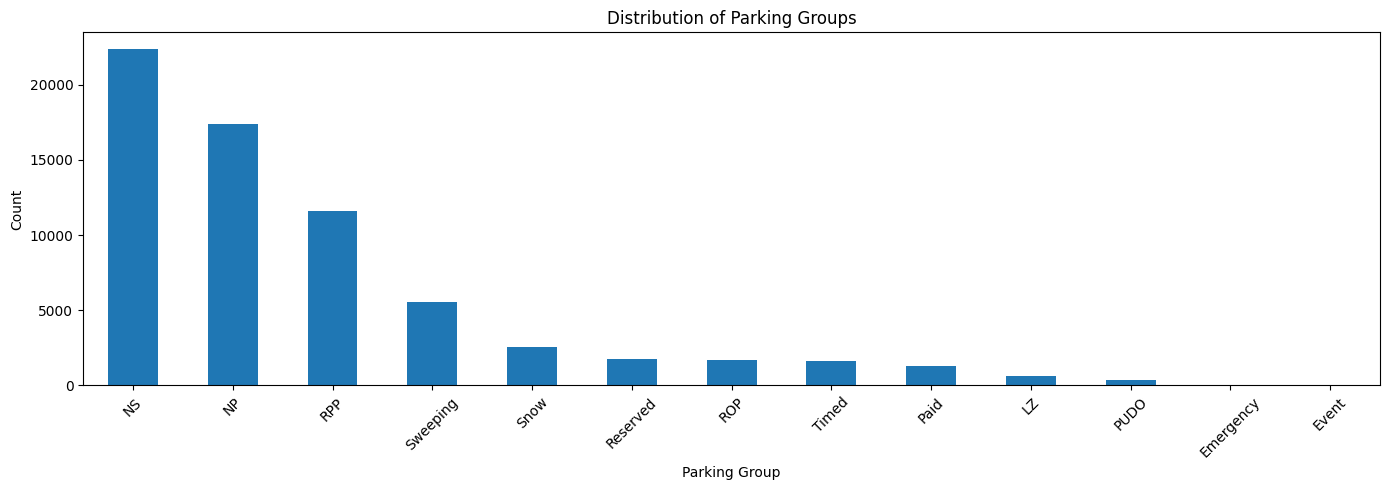

In [8]:
import matplotlib.pyplot as plt

# Distribution of parking groups
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

parking_zones['PARKINGGROUP'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Distribution of Parking Groups')
ax.set_xlabel('Parking Group')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)

# Create a summary table of unrestricted hours by parking group
summary_table = parking_zones.groupby('PARKINGGROUP')['UNRESTRICTED_HOURS_PER_WEEK'].describe()
display(summary_table)

plt.tight_layout()
plt.show()

## Parking Space Amounts

Due to inconsistencies in DC Data (opendata.dc.gov), we will have to approximate the max amount parking spaces are available based on the lengths of the zones. We convert the dataframe onto projected coordinate system, which allows us to get accurate distance mesurements. Then we approximate other measurements (car length, account for impediments like driveways and firehydrants) to calculate the max amount parking spaces over a specific zone. 

In [107]:
# using geometry to calculate zone length, then use that, accounting for car length and impidents for an estimatee MAX number of cars that can park in each zone

#convert first to projected coordinate system (meters)
parking_zones = parking_zones.to_crs(epsg=2263)
parking_zones["ZONE_LENGTH_M"] = parking_zones.geometry.length
print(parking_zones["ZONE_LENGTH_M"].describe())
average_car_length_m = 4.5  # average car length in meters
impediment_factor = 1  # factor to account for impediments like driveways, fire hydrants, etc. SUBJECT TO CHANGE

# Calculate estimated max cars, round, set negatives to 0, and cast to Int64
estimated_cars = (parking_zones["ZONE_LENGTH_M"] / (average_car_length_m * impediment_factor))
estimated_cars = estimated_cars.round()
estimated_cars[estimated_cars < 0] = 0
parking_zones["ESTIMATED_MAX_CARS"] = estimated_cars.astype('Int64')

#Print out the final dataframe
parking_zones["ESTIMATED_MAX_CARS"].describe()
plt.show()

count    66880.000000
mean       178.012037
std        282.487113
min          0.006565
25%         37.882297
50%         89.730325
75%        238.155897
max      15833.207535
Name: ZONE_LENGTH_M, dtype: float64


In [108]:
parking_zones["ESTIMATED_MAX_CARS"].sum()


np.int64(2645536)

In [109]:
parking_zones.head(10)

,ZONEID,PARKINGGROUP,geometry,STARTDAY,ENDDAY,STARTTIME,ENDTIME,SIDE,DATA_ERRORS,PARKINGDAYGROUP,PARKINGHOURGROUP,RESTRICTED_HOURS_PER_WEEK,RESTRICTED_DAYS_PER_WEEK,RESTRICTED_DAYS_PER_WEEK_ERROR,RESTRICTED_HOURS_PER_WEEK_ERROR,UNRESTRICTED_HOURS_PER_WEEK,ZONE_LENGTH_M,ESTIMATED_MAX_CARS
0,0554646e4ee531da24e77654c470d839-right-0,NS,"LINESTRING Z (117867.726 -444387.753 0, 117849...",8,8,100.0,100.0,right,Missing: |,Anyday,Anytime,168.000000,7.0,,,0.000000,18.512063,4
1,0c47cb0e8c933ea13ad583dde1daca32-left-4,Timed,"LINESTRING Z (109416.833 -427688.896 0, 108615...",8,8,100.0,100.0,left,Missing: |,Anyday,Anytime,168.000000,7.0,,,14.000000,801.580745,178
2,0c44fd00a5eaecc9aad8032dc4b85078-right-2,RPP,"LINESTRING Z (129434.757 -442288.337 0, 129606...",1,5,13.0,67.0,right,Missing: |,Weekdays,Full Day,54.000000,5.0,,,114.000000,172.054602,38
3,0fb9867d79da28635d30a2a713ef98f4-left-1,NS,"LINESTRING Z (148803.259 -449251.732 0, 148803...",8,8,100.0,100.0,left,Missing: |,Anyday,Anytime,168.000000,7.0,,,0.000000,0.896228,0
4,107d16da371cb52a261d84dd2c7864f0-left-3,NP,"LINESTRING Z (121739.324 -444509.295 0, 121740...",8,8,100.0,100.0,left,Missing: |,Anyday,Anytime,168.000000,7.0,,,0.000000,25.465096,6
5,0f8cfafd2eb75fd4858f663b3cc6a01f-right-1,Timed,"LINESTRING Z (124689.01 -420306.84 0, 124310.6...",7,7,17.0,NaN,right,Missing: Time Restriction |,Sunday,ERROR WITH HOURS,46.962925,NaN,Invalid day range,Invalid or missing time range,NaN,378.672955,84
6,006241f348c0e38460851214ec6c14ac-left-1,NS,"LINESTRING Z (111684.04 -432471.82 0, 111689.0...",8,8,100.0,100.0,left,Missing: |,Anyday,Anytime,168.000000,7.0,,,0.000000,114.082443,25
7,01a328aecdf9cb8ab75a0a5dc9e58604-left-7,NS,"LINESTRING Z (116765.711 -447861.034 0, 116770...",1,5,49.0,NaN,left,Missing: Time Restriction |,Weekdays,ERROR WITH HOURS,141.389978,5.0,,Invalid or missing time range,26.610022,452.088011,100
8,0c6c5293834c537a9a56d500c8c74ecb-right-1,NS,"LINESTRING Z (122786.761 -426512.029 0, 122739...",8,8,100.0,100.0,right,Missing: |,Anyday,Anytime,168.000000,7.0,,,0.000000,47.700539,11
9,06f4071cc14698bbe81219b64203dc91-left-0,NS,"LINESTRING Z (111359.239 -424281.219 0, 111339...",8,8,100.0,100.0,left,Missing: |,Anyday,Anytime,168.000000,7.0,,,0.000000,35.740822,8


In [110]:
parking_zones.describe()

,STARTDAY,ENDDAY,STARTTIME,ENDTIME,RESTRICTED_HOURS_PER_WEEK,RESTRICTED_DAYS_PER_WEEK,UNRESTRICTED_HOURS_PER_WEEK,ZONE_LENGTH_M,ESTIMATED_MAX_CARS
count,66979.000000,66979.000000,66974.000000,66960.000000,66979.000000,60742.000000,66851.000000,66880.000000,66880.0
mean,5.441079,6.683677,68.797892,82.293578,110.092199,6.098295,58.046290,178.012037,39.556459
std,3.274916,1.863400,39.876318,24.811529,68.683623,1.576259,68.929398,282.487113,62.776947
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.006565,0.0
25%,1.000000,5.000000,13.000000,67.000000,54.000000,5.000000,0.000000,37.882297,8.0
50%,8.000000,8.000000,100.000000,100.000000,168.000000,7.000000,0.000000,89.730325,20.0
75%,8.000000,8.000000,100.000000,100.000000,168.000000,7.000000,114.000000,238.155897,53.0
max,9.000000,9.000000,100.000000,100.000000,168.000000,7.000000,176.000000,15833.207535,3518.0


### Exporting our data:

In [111]:
# Export cleaned parking zones data
output_file = "../cleaned_data/cleaned_parking_zones.geojson"

parking_zones.to_file(output_file, driver="GeoJSON")

## Basic Visualization

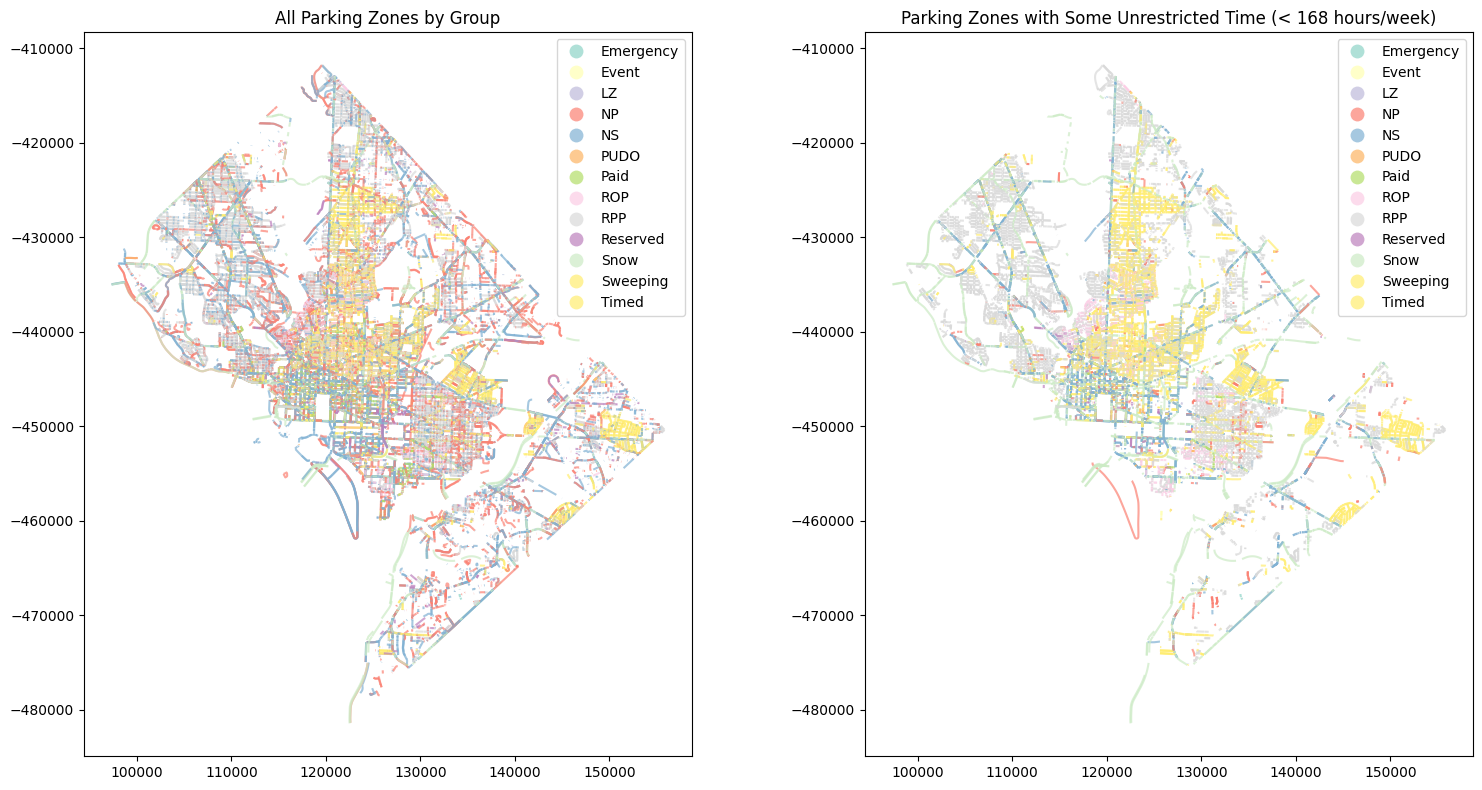

Total parking zones: 66979
Zones with some unrestricted time: 28851
Percentage with unrestricted time: 43.1%


In [112]:
# Visualize parking zones vs zones with less than 168 hours restriction (i.e., some unrestricted time)
zones_with_unrestricted = parking_zones[parking_zones["RESTRICTED_HOURS_PER_WEEK"] < 168]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

parking_zones.plot(column='PARKINGGROUP', ax=ax1, legend=True, cmap='Set3', alpha=0.7)
ax1.set_title('All Parking Zones by Group')

zones_with_unrestricted.plot(column='PARKINGGROUP', ax=ax2, legend=True, cmap='Set3', alpha=0.7)
ax2.set_title('Parking Zones with Some Unrestricted Time (< 168 hours/week)')

plt.tight_layout()
plt.show()

print(f"Total parking zones: {len(parking_zones)}")
print(f"Zones with some unrestricted time: {len(zones_with_unrestricted)}")
print(f"Percentage with unrestricted time: {len(zones_with_unrestricted)/len(parking_zones)*100:.1f}%")